<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Catboost" data-toc-modified-id="Catboost-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LogisticRegression</a></span></li></ul></li><li><span><a href="#Тестирование-модели-LogisticRegression" data-toc-modified-id="Тестирование-модели-LogisticRegression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование модели LogisticRegression</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Проект для "Викишоп" с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка признаков

Импортируем нужные библиотеки

In [4]:
import pandas as pd
import numpy as np
import transformers
from tqdm import notebook
import torch

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBRFClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
df_toxic = pd.read_csv('datasets/toxic_comments.csv')
df_toxic.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Уберем неинформативный столбец "Unnamed: 0"

In [6]:
df_toxic = df_toxic.drop(['Unnamed: 0'], axis=1)
df_toxic

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


Посмотрим на общее соотношение токсичных комментариев к не токсичным

<AxesSubplot: xlabel='toxic'>

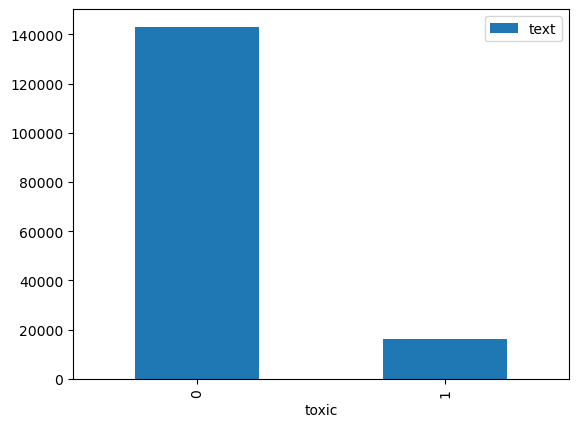

In [7]:
df_toxic.pivot_table(index='toxic',values='toxic', aggfunc='count').plot(kind='bar')

Как видно из графика выше, в данных сильный дисбаланс в сторону не токсичных комментариев, что может сильно повлиять на итоговый показатель качества модели

Проверим количество пропущенных значений и дубликатов в датасете

In [8]:
df_toxic.isna().sum()

text     0
toxic    0
dtype: int64

In [9]:
df_toxic.duplicated().sum()

0

Ввиду ограниченности вычислительных ресурсов, для дальнейшей работы возьмем выборку из 10000 строк 

In [10]:
df_toxic = df_toxic.sample(10000, random_state=12345)

Проведем токенизацию и пэддинг признаков

In [11]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')


tokenized = df_toxic['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

2023-04-10 13:44:13.859896: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Возьмем модель Bert Base Uncased (https://huggingface.co/bert-base-uncased) и с ее помощью обработаем комментарии

In [12]:
model = transformers.BertModel.from_pretrained(
    "bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
batch_size = 10
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/1000 [00:00<?, ?it/s]

Разобьем данные на обучающую и тестовую выборки в соотношении 1/4

In [163]:
X = np.concatenate(embeddings)

y = df_toxic['toxic']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, random_state=12345)

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(8000, 768)
(2000, 768)
(8000,)
(2000,)


## Обучение моделей

### Catboost

In [170]:
%%time
model_CB = CatBoostClassifier(iterations=100, learning_rate=.1, depth=2, verbose=10)
score = cross_val_score(model_CB, X_train, y_train, scoring=make_scorer(f1_score, average='weighted'), cv=10).mean()

0:	learn: 0.5877975	total: 20ms	remaining: 1.98s
10:	learn: 0.2773826	total: 74.8ms	remaining: 605ms
20:	learn: 0.2268966	total: 132ms	remaining: 495ms
30:	learn: 0.2056648	total: 208ms	remaining: 463ms
40:	learn: 0.1921568	total: 267ms	remaining: 384ms
50:	learn: 0.1827092	total: 322ms	remaining: 309ms
60:	learn: 0.1757899	total: 377ms	remaining: 241ms
70:	learn: 0.1698199	total: 437ms	remaining: 179ms
80:	learn: 0.1648309	total: 495ms	remaining: 116ms
90:	learn: 0.1596755	total: 554ms	remaining: 54.8ms
99:	learn: 0.1554440	total: 611ms	remaining: 0us
0:	learn: 0.5959338	total: 6.34ms	remaining: 628ms
10:	learn: 0.2723346	total: 70.8ms	remaining: 573ms
20:	learn: 0.2254477	total: 135ms	remaining: 508ms
30:	learn: 0.2049953	total: 203ms	remaining: 452ms
40:	learn: 0.1928076	total: 274ms	remaining: 394ms
50:	learn: 0.1838086	total: 332ms	remaining: 319ms
60:	learn: 0.1759068	total: 393ms	remaining: 251ms
70:	learn: 0.1698443	total: 454ms	remaining: 186ms
80:	learn: 0.1650502	total: 519m

In [171]:
print(f'Catboost F1 score: {score:.3f}')

Catboost F1 score: 0.924


### LightGBM

In [174]:
%%time
model_LGBM = None
n_est = None
depth = None 
score = 0
for n_est in notebook.tqdm(range(20, 101, 20)):
    for depth in notebook.tqdm(range(1, 5, 1)):
        model = LGBMClassifier(learning_rate=.1, n_estimators=n_est, max_depth=depth)
        cv = cross_val_score(
            model,
            X_train,
            y_train,
            scoring=make_scorer(f1_score, average='weighted'),
            cv=10).mean()
        if cv > score:
            model_LGBM = model
            n_est = n_est
            depth = depth
            score = cv

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 12min 58s, sys: 1min 10s, total: 14min 9s
Wall time: 1min 54s


In [175]:
print(f'LightGBM Cross-val score: {score:.3f}')

LightGBM Cross-val score: 0.930


### LogisticRegression

In [180]:
%%time
model_LR = LogisticRegression(solver='saga', max_iter=100)
score = cross_val_score(model_LR, X_train, y_train, scoring=make_scorer(f1_score, average='weighted'), cv=10).mean()

/Users/denisusupov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/denisusupov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/denisusupov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/denisusupov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/denisusupov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: Convergence

CPU times: user 36.6 s, sys: 2.45 s, total: 39.1 s
Wall time: 37.6 s


/Users/denisusupov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [181]:
print(f'LogisticRegression Cross-val score: {score:.3f}')

LogisticRegression Cross-val score: 0.941


По итогам кросс-валидационного скоринга моделей можно отметить, что самой быстрой оказалась модель CatBoost(время исполнения блока - 9.05 секунд, F1 score - 0.924), такой же показатель скорости (без учета оптимизации) показала модель LightGBM с F1 score - 0.93, лучший показатель F1 score показала модель LogisticRegression - 0.941.

Потому, выберем модель LogisticRegression для дальнейшего тестирования.

## Тестирование модели LogisticRegression

In [179]:
model_LR.fit(X_train, y_train)

predictions = model_LR.predict(X_test)
score = f1_score(y_test, predictions)
print(f'F1 score модели LogisticRegression: {score:.2f}')

F1 score модели LogisticRegression: 0.75


/Users/denisusupov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Как видно по показателю выше, итоговое значение метрики F1 для модели LogisticRegression равно 0.75

## Вывод

В ходе исследования с помощью модели BERT были обработанны и закодированны текстовые признаки, далее были обучены три модели машинного обучения - CatBoost, LightGBM и LogisticRegression, по результатам тестирования которых, была выбрана лучшая модель LogisticRegression, итоговый показатель качества которой, по метрике F1, составил 0.75. 

Это значение можно сильно улучшить обработав всю генеральную совокупность данных моделью BERT и использовав эти данные для обучения и тестирования моделей, но, ввиду ограниченности вычислительных ресурсов, было решено взять выборку из всего 10000 строк, что сильно сказалось на итоговых показателях качества модели.


Были проделаны следующие шаги:
- Проанализированн и предобработан датасет.
- Обработаны и закодированны текстовые признаки с помощью модели BERT.
- Обучены и проанализированы 3 модели машинного обучения.
- Выбрана и проверена наилучшая по показателям качества модель.